In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import nltk 
import spacy

import pandas as pd
import numpy as np
import re
from tqdm.notebook import tqdm
tqdm.pandas()

import joblib
import emoji

from annoy import AnnoyIndex

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

from sentence_transformers import SentenceTransformer

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.fasttext import FastText

from wordcloud import WordCloud, STOPWORDS
from nltk import sent_tokenize, word_tokenize, regexp_tokenize

In [4]:
#import lightgbm
nltk.__version__

'3.7'

In [5]:
#nltk.download('stopwords') 
stopwords_nltk = nltk.corpus.stopwords.words('russian') #лист русский стоп-слов 
stopwords_nltk_en = nltk.corpus.stopwords.words('english') 
stopwords_nltk.extend(stopwords_nltk_en) #часть текста а английском 
#new_stop = ['т.п.', 'т.е.']
new_stop = ['здравствовать', 'подсказать', 'сказать', "пожалуйста", "спасибо",  "благодарить", "извинить",
            'вопрос','тема', "ответ", "ответить", "почему", "что",
            'которая', 'которой', 'которую', 'которые', 'который', 'которых', 'это', "мочь",
            'вообще', "всё", "весь", "ещё", "просто",  "якобы", "причём", 'точно', "хотя", "именно", 'неужели',
             "г", "ул", "город", "улица"]
stopwords_nltk.extend(new_stop) 

lemmatizer = spacy.load('ru_core_news_md', disable = ['parser', 'ner'])

In [6]:
#stopwords_nltk

In [7]:
#очистка текста
def full_clean(text):
    '''подготовка текста к подаче в модель через applay'''
    text = emoji.demojize(text)
    text=re.sub(r"[^a-zA-Zа-яА-ЯёЁ0-9#]", " ", text)
    text = text.lower()
    text = re.sub(" +", " ", text) #оставляем только 1 пробел
    text = text.replace("добрый день", "").replace("добрый вечер", "").replace("доброе утро", "").replace("сообщение без текста", "").replace("да подтверждаю", "").replace("до сих пор", "")
    text = text.strip()
    #токены для моделей
    tokens = [token.lemma_ for token in lemmatizer(text) if token.lemma_ not in stopwords_nltk]
    #для tfidf на вход текст
    text = " ".join(tokens)
    return text, tokens

def preprocess_text(df):
    '''подготовка текста к подаче в модель колонкой'''
    new_corpus=[]
    new_tokens=[]

    for text in tqdm(df):
        text = emoji.demojize(text)
        text=re.sub(r"[^a-zA-Zа-яА-ЯёЁ0-9#]", " ", text)
        text = text.lower()
        text = re.sub(" +", " ", text) #оставляем только 1 пробел
        text = text.replace("добрый день", "").replace("добрый вечер", "").replace("доброе утро", "").replace("сообщение без текста", "").replace("да подтверждаю", "").replace("до сих пор", "")
        text = text.strip()
        #токены для моделей
        tokens = [token.lemma_ for token in lemmatizer(text) if token.lemma_ not in stopwords_nltk]
        #для tfidf на вход текст
        text = " ".join(tokens)

        new_corpus.append(text)
        new_tokens.append(tokens)
        
    return new_corpus, new_tokens

def preprocess_text(df):
    '''подготовка текста к подаче в модель колонкой'''
    new_corpus=[]
    new_tokens=[]

    for text in tqdm(df):
        text, tokens = full_clean(text)
        new_corpus.append(text)
        new_tokens.append(tokens)
        
    return new_corpus, new_tokens

In [8]:
def tfidf_fit(train=None, test=None, tfidf=True, ngram_range=(1, 1), max_features=1000, save=False):
    #на вход текст
    #min_df : игнорируются термины, частота употребления которых строго ниже заданного порога.
    #max_df : игнорируются термины, частота которых строго превышает заданный порог
    if test:
        data = pd.concat([train, test])
    else:
        data = train
    if tfidf:        
        model = TfidfVectorizer(ngram_range=(1, 1), max_features=max_features, analyzer='word', #max_df = 0.9,
                            lowercase = False, sublinear_tf=True)
    else:
        model = CountVectorizer(max_features=max_features) 
    #тренировка
    model.fit(data)
    #feature_names = model.get_feature_names_out()
    
    #сохранение натренированной модели для приложения
    if save:
        joblib.dump(model, 'tfidf.pkl') 
        
    return model
    
def tfidf_embeding(model=None, df=None):   
    '''Преобразование текста в мешок слов'''
    if model==None:
        #загрузить если нет
        model = joblib.load('tfidf.pkl')
    else:
        model=model
    X = model.transform(df)
    #feature_names = model.get_feature_names_out()
    #X = pd.DataFrame(model.toarray(), columns = feature_names, index = df.index)
    
    return X.toarray()#.tolist()

In [9]:
def validation(name, model, X_valid, y_valid, report=True, importances=True):
    class_names=pd.Series(y_valid).value_counts().index.tolist()
    #class_names=np.unique(y_valid)
    #feature_names X_valid.columns
    #feature_names = tfidf.get_feature_names_out()
    if name == "catc":
        #model.set_probability_threshold(0.495)
        model_valid = model.predict(X_valid)
        model_valid_ = model.predict_proba(X_valid)[:, 1]
        #model_valid = (model.predict_proba(valid[features])[:, 1]>= threshold).astype(int)
    elif name == "lgbc":
        model_valid = model.predict(X_valid)
        model_valid_ = model.predict_proba(X_valid)[:, 1]
    elif name == "logit":
        model_valid = model.predict(X_valid)
        model_valid_ = model.predict_proba(X_valid)[:, 1]
    #расчет метрики
    print("f1_weight: ", f1_score(y_valid, model_valid, average='weighted'))
    #print("roc_auc: ", roc_auc_score(y_valid, model_valid_, average='weighted', multi_class="ovr"))  #'macro'
    
    if report==True:
        print("Отчет о классификации: ")
        print(classification_report(y_valid, model_valid, zero_division=0, labels=class_names))
        #матрица ошибок
        print("Матрица ошибок: ")
        cm = confusion_matrix(y_valid, model_valid, labels=class_names)#, normalize='true'
        cm_display = ConfusionMatrixDisplay(cm, display_labels=class_names).plot(colorbar=False, cmap="GnBu") 

    if importances==True:
        fig, ax = plt.subplots(figsize=(8, 6))
        if name == "catc":
            #влияющие факторы
            fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': feature_names})
            fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-20:]
            #fea_imp.plot(kind='barh', x='col', y='imp', figsize=(8, 6), legend=None)
            ax.barh(fea_imp['col'], fea_imp['imp'], align='center')
        
        elif name == "lgbc":
            #model.plot_importance(lgbc, max_num_features=20, height=0.8, ax=ax)
            fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': feature_names})
            fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-20:]
            #fea_imp.plot(kind='barh', x='col', y='imp', figsize=(8, 6), legend=None)
            ax.barh(fea_imp['col'], fea_imp['imp'], align='center')
        elif name == "logit":
            #logit.coef_ среднее по всем классам
            fea_imp = pd.DataFrame({'imp': np.mean(logit.coef_, axis=0), 'col': feature_names})
            fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-20:]
            ax.barh(fea_imp['col'], fea_imp['imp'], align='center')
        
        plt.title('Важность признаков для модели')   
        plt.ylabel('Признаки')
        plt.xlabel('Важность')

In [10]:
def index_annoy(X_train_part):
    #построение индекса
    #"angular", "euclidean", "manhattan", "hamming", or "dot" 384 768 1024
    #emb_len = X_train_part.shape[1]
    emb_len=len(X_train_part[0])
    t = AnnoyIndex(emb_len, metric = 'angular')

    # train['id'], 
    for user_id, user_embedding in enumerate(X_train_part):
        t.add_item(user_id, user_embedding)
    t.build(-1)
    
    return t

def predict_nns_(t, X_valid):
    #через apply
    idx = t.get_nns_by_vector(X_valid, 1, search_k=-1)  
    return train_part[idx].values[0]

def predict_nns(t, X_valid):
    #для массива срезу
    predict=[]
    for emb in tqdm(X_valid):
        idx = t.get_nns_by_vector(emb, 1, search_k=-1)[0] 
        predict.append(y_train_part[idx])
    return predict

In [11]:
def doc2vec_fit(train=None, test=None, vector_size=100, save=False):
    #на вход токены gensim
    if test:
        data = pd.concat([train, test])
    else:
        data = train
        
    common_texts=data.tolist()
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(common_texts)]
    model = Doc2Vec(documents, vector_size=vector_size, window=5, min_count=1, workers=8)
    #тренировка
    model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)
    
    #сохранение натренированной модели для приложения
    if save:
        joblib.dump(model, 'doc2vec.pkl') 
        
    return model
    
def doc2vec_embeding(model=None, df=None):   
    '''Преобразование токенов в Doc2Vec'''
    if model==None:
        #загрузить если нет
        model = joblib.load('doc2vec.pkl')
    else:
        model=model
    embeding =[]
    for tokens in tqdm(df):
        embeding.append(model.infer_vector(tokens).tolist())
    
    return embeding

In [12]:
def postpredict(model, X_valid, lim=0.1):
    #если уверенность в метке низкая ииспользуем другой классификатор
    
    #t = index_annoy(X_train_part)
    logit_class = list(model.classes_)
    
    model_valid = model.predict(X_valid)
    model_valid_ = model.predict_proba(X_valid)
    
    scores = []
    model_valid_new=[]
    lim=lim
    for i in range(len(model_valid)):
        #класс, вероятность
        #print(model_valid[i], model_valid_[i][logit_class.index(model_valid[i])])
        score = model_valid_[i][logit_class.index(model_valid[i])]
        scores.append(score)
        if score >= lim:
            model_valid_new.append(model_valid[i])
        elif score < lim:
            #idx = t.get_nns_by_vector(X_valid[i], 1, search_k=-1)[0] 
            #model_valid_new.append(y_train_part[idx])
            model_valid_new.append(catc.predict(X_valid[i])[0])
            
    return model_valid_new

In [13]:
def plot_wordCloud(title, object_):
    regexp=r'(?u)\b\w{4,}\b'

    text = str(train[train[title]==object_]['text_clean'].tolist())

    words = [w for sent in sent_tokenize(text) for w in regexp_tokenize(sent, regexp)]

    wordCloud = WordCloud(random_state=1, background_color='white', colormap='Set2', 
                          max_words=100).generate(' '.join(words))

    plt.figure(figsize=(12,12))
    plt.title(title + ': ' + object_ , fontsize=18) 
    plt.imshow(wordCloud)
    plt.axis("off")

In [14]:
train = pd.read_csv('data/train_dataset_train.csv', sep=';', index_col=None)
train.head()

,Исполнитель,Группа тем,Текст инцидента,Тема
0,Лысьвенский городской округ,Благоустройство,"'Добрый день. Сегодня, 20.08.22, моя мать шла ...",★ Ямы во дворах
1,Министерство социального развития ПК,Социальное обслуживание и защита,"'Пермь г, +79194692145. В Перми с ноября 2021 ...",Оказание гос. соц. помощи
2,Министерство социального развития ПК,Социальное обслуживание и защита,'Добрый день ! Скажите пожалуйста если подовал...,Дети и многодетные семьи
3,Город Пермь,Общественный транспорт,'Каждая из них не о чем. Люди на остановках хо...,Содержание остановок
4,Министерство здравоохранения,Здравоохранение/Медицина,'В Березниках у сына привитого откоронавируса ...,Технические проблемы с записью на прием к врачу


In [15]:
train['text_clean'], train['tokens']=preprocess_text(train['Текст инцидента'])

  0%|          | 0/23128 [00:00<?, ?it/s]

In [12]:
#если надо будет метки в числах
#codes, uniques = pd.factorize(train["Тема"])
#train['label']=codes
#uniques

In [16]:
train.head()

,Исполнитель,Группа тем,Текст инцидента,Тема,text_clean,tokens
0,Лысьвенский городской округ,Благоустройство,"'Добрый день. Сегодня, 20.08.22, моя мать шла ...",★ Ямы во дворах,сегодня 20 08 22 мать идти ленин дом 96 94 фон...,"[сегодня, 20, 08, 22, мать, идти, ленин, дом, ..."
1,Министерство социального развития ПК,Социальное обслуживание и защита,"'Пермь г, +79194692145. В Перми с ноября 2021 ...",Оказание гос. соц. помощи,пермь 79194692145 пермь ноябрь 2021 год работа...,"[пермь, 79194692145, пермь, ноябрь, 2021, год,..."
2,Министерство социального развития ПК,Социальное обслуживание и защита,'Добрый день ! Скажите пожалуйста если подовал...,Дети и многодетные семьи,подовала пособие 3 7 2 декабрь повторно подать...,"[подовала, пособие, 3, 7, 2, декабрь, повторно..."
3,Город Пермь,Общественный транспорт,'Каждая из них не о чем. Люди на остановках хо...,Содержание остановок,каждый человек остановка хотеть укрыться непог...,"[каждый, человек, остановка, хотеть, укрыться,..."
4,Министерство здравоохранения,Здравоохранение/Медицина,'В Березниках у сына привитого откоронавируса ...,Технические проблемы с записью на прием к врачу,березниках сын привитого откоронавируса заболе...,"[березниках, сын, привитого, откоронавируса, з..."


In [17]:
#пустые чаще к Социальное обслуживание и защита
train[train['text_clean']=='']['Группа тем'].value_counts()

Группа тем
Социальное обслуживание и защита            94
Дороги                                      56
Благоустройство                             55
Здравоохранение/Медицина                    50
Мусор/Свалки/ТКО                            41
ЖКХ                                         35
Общественный транспорт                       9
Связь и телевидение                          8
Безопасность                                 8
Образование                                  7
Строительство и архитектура                  7
Мобилизация                                  5
Спецпроекты                                  3
Коронавирус                                  3
Газ и топливо                                2
Экономика и бизнес                           2
Государственная собственность                2
Физическая культура и спорт                  1
Памятники и объекты культурного наследия     1
Культура                                     1
Name: count, dtype: int64

In [18]:
train = train[train['text_clean']!=""]

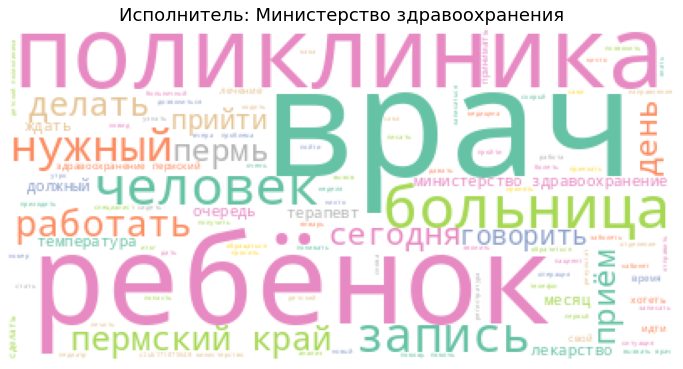

In [19]:
plot_wordCloud('Исполнитель', "Министерство здравоохранения")

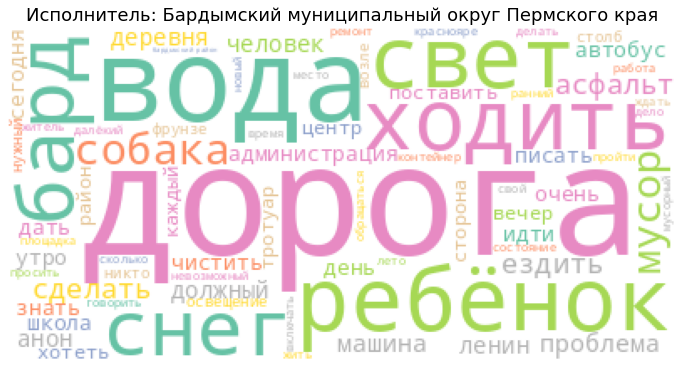

In [20]:
plot_wordCloud('Исполнитель', "Бардымский муниципальный округ Пермского края")

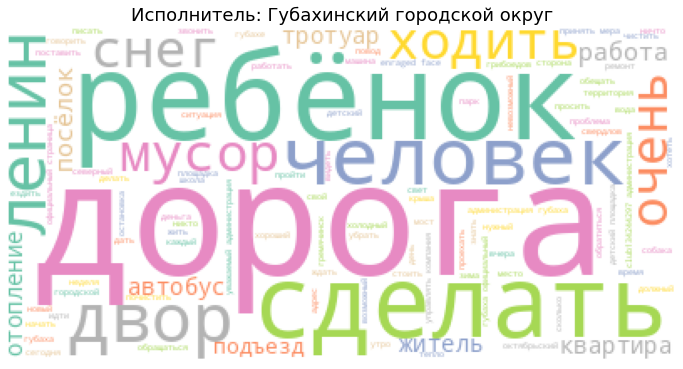

In [21]:
plot_wordCloud('Исполнитель', "Губахинский городской округ")

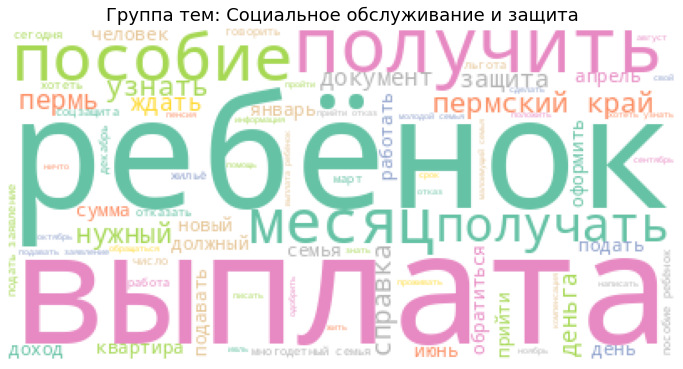

In [22]:
plot_wordCloud('Группа тем', "Социальное обслуживание и защита")

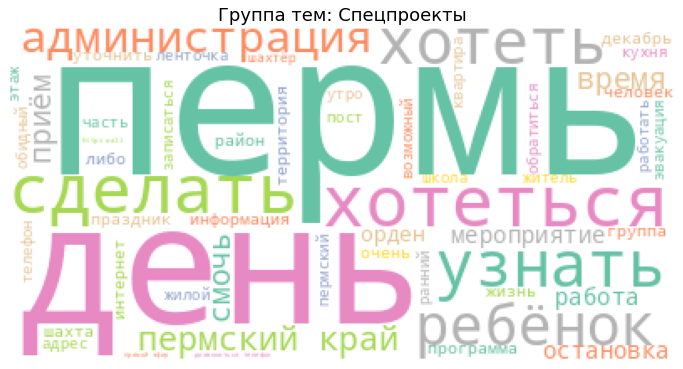

In [23]:
plot_wordCloud('Группа тем', "Спецпроекты")

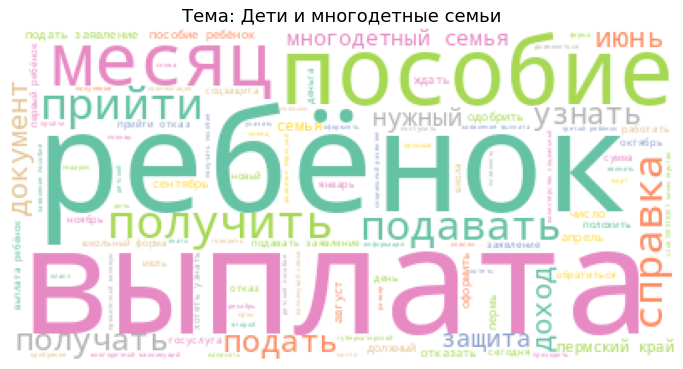

In [24]:
plot_wordCloud('Тема', "Дети и многодетные семьи")

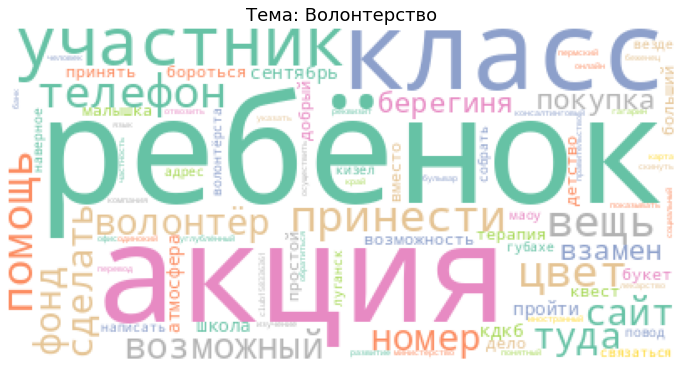

In [25]:
plot_wordCloud('Тема', "Волонтерство")

### Векторы tfidf

In [26]:
tfidf = tfidf_fit(train=train['text_clean'], tfidf=True, max_features=5000)
feature_names = tfidf.get_feature_names_out()
len(feature_names)

5000

In [27]:
tfidf_embed = tfidf_embeding(model=tfidf, df=train['text_clean'])

In [32]:
#сохранить модель
#joblib.dump(tfidf, 'model/tfidf.pkl') 
#загрузить если нет
#tfidf = joblib.load('model/tfidf.pkl')

['model/tfidf.pkl']

In [29]:
#tfidf_ = tfidf_fit(train=train['text_clean'], tfidf=True, ngram_range=(1, 2), max_features=1000)
#feature_names_ = tfidf_.get_feature_names_out()
#len(feature_names)

In [30]:
#tfidf_embed_ = tfidf_embeding(model=tfidf_, df=train['text_clean'])

#### Векторы SentenceTransformer

In [31]:
data = train['Текст инцидента'].tolist()

In [395]:
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
embeddings = model.encode(data, show_progress_bar=True)

Batches:   0%|          | 0/711 [00:00<?, ?it/s]

### Векторы Doc2Vec

In [200]:
doc2vec = doc2vec_fit(train=train['tokens'], test=None, vector_size=300, save=False)

In [201]:
doc2vec_embed = doc2vec_embeding(model=doc2vec, df=train['tokens'])

  0%|          | 0/22732 [00:00<?, ?it/s]

In [93]:
#X = tfidf.transform(["Здравствуйте, уточните в какую погоду дети начальной школы должны заниматься весной и осенью на улице ? Какие ограничения по температурному режиму и погодным условиям ?"])
#X

<1x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

## Исполнитель

In [33]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(tfidf_embed, 
                                                                train['Исполнитель'].tolist(), 
                                                                stratify = train['Исполнитель'],
                                                                random_state=44, test_size=0.2)

In [34]:
#"liblinear" => "ovr" 
#"multinomial" => newton-cg, sag, saga и lbfgs
logit = LogisticRegression(solver = "lbfgs", C=1.0, class_weight="balanced", max_iter=200, multi_class="ovr")
logit.fit(X_train_part, y_train_part)

LogisticRegression(class_weight='balanced', max_iter=200, multi_class='ovr')

In [35]:
# save the model to disk
joblib.dump(logit, 'model/logit_otdel.sav')
 
# load the model from disk
#logit = joblib.load('model/flogit_otdel.sav')

['model/logit_otdel.sav']

f1_weight:  0.7818753607644265
Отчет о классификации: 
                                                    precision    recall  f1-score   support

                      Министерство здравоохранения       0.95      0.92      0.93      1141
                                       Город Пермь       0.74      0.74      0.74       890
              Министерство социального развития ПК       0.92      0.90      0.91       860
                       Лысьвенский городской округ       0.59      0.59      0.59       406
                                           ИГЖН ПК       0.72      0.74      0.73       366
                                        АО ПРО ТКО       0.75      0.83      0.79       297
                       Губахинский городской округ       0.55      0.47      0.51       216
Александровский муниципальный округ Пермского края       0.56      0.53      0.54       195
                          Министерство образования       0.56      0.75      0.64       102
     Бардымский муниципа

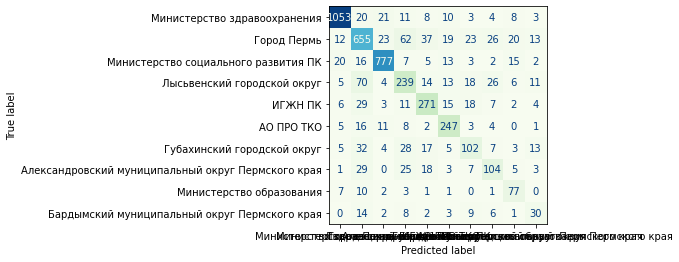

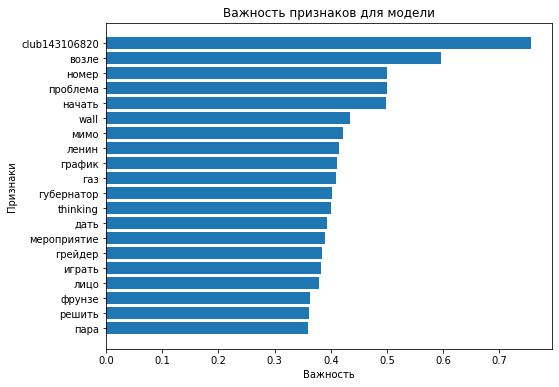

In [36]:
validation('logit', logit, X_valid, y_valid)

In [37]:
model_valid = logit.predict(X_valid)

In [38]:
#model_valid = logit.predict(X)
#model_valid[0]

In [39]:
class_names=pd.Series(y_valid).value_counts().index.tolist()
report = classification_report(y_valid, model_valid, zero_division=0, labels=class_names, output_dict=True, digits=2)
df_rep = pd.DataFrame.from_dict(report).transpose().round(2)
df_rep.head()

,precision,recall,f1-score,support
Министерство здравоохранения,0.95,0.92,0.93,1141.0
Город Пермь,0.74,0.74,0.74,890.0
Министерство социального развития ПК,0.92,0.90,0.91,860.0
Лысьвенский городской округ,0.59,0.59,0.59,406.0
ИГЖН ПК,0.72,0.74,0.73,366.0


### кэтбуст

In [40]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(tfidf_embed, 
                                                                train['Исполнитель'].tolist(), 
                                                                stratify = train['Исполнитель'],
                                                                random_state=42, test_size=0.2)

In [41]:
catc = CatBoostClassifier(loss_function='MultiClass', 
                          eval_metric="TotalF1",  
                          learning_rate=0.25, 
                          max_depth = 6, 
                          n_estimators = 8000, 
                          auto_class_weights='Balanced',
                          #l2_leaf_reg = 1.5,
                          #bagging_temperature=0.1,
                          #colsample_bylevel=0.7,
                          #subsample=0.7,
                          leaf_estimation_iterations=1, random_state=42, task_type='GPU')
catc.fit(X_train_part, y_train_part, eval_set=(X_valid, y_valid), cat_features=None,
         early_stopping_rounds = 100, use_best_model=True, verbose=500)

0:	learn: 0.2317979	test: 0.2260008	best: 0.2260008 (0)	total: 62.5ms	remaining: 8m 19s
bestTest = 0.6414069608
bestIteration = 324
Shrink model to first 325 iterations.


f1_weight:  0.6989770114777278
Отчет о классификации: 
                                                    precision    recall  f1-score   support

                      Министерство здравоохранения       0.92      0.79      0.85      1141
                                       Город Пермь       0.60      0.60      0.60       890
              Министерство социального развития ПК       0.86      0.81      0.83       860
                       Лысьвенский городской округ       0.54      0.49      0.52       406
                                           ИГЖН ПК       0.72      0.69      0.70       366
                                        АО ПРО ТКО       0.68      0.80      0.73       297
                       Губахинский городской округ       0.47      0.47      0.47       216
Александровский муниципальный округ Пермского края       0.43      0.56      0.49       195
                          Министерство образования       0.42      0.77      0.54       102
     Бардымский муниципа

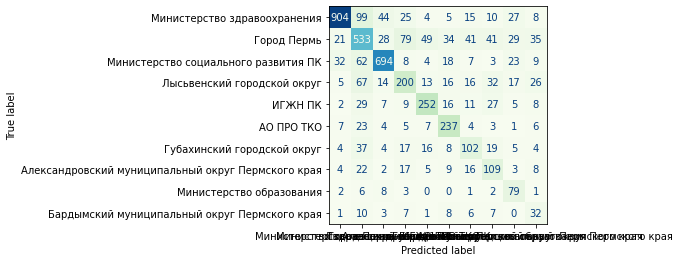

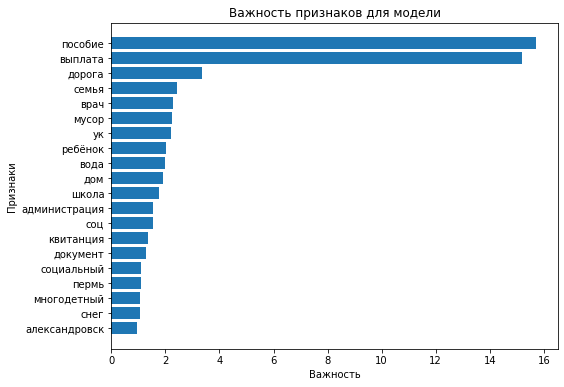

In [42]:
validation('catc', catc, X_valid, y_valid)

In [43]:
model_valid_new = postpredict(logit, X_valid)
print("f1_weight: ", f1_score(y_valid, model_valid_new, average='weighted'))

f1_weight:  0.8640518871941283


In [ ]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(embeddings, 
                                                                train['Исполнитель'].tolist(), 
                                                                stratify = train['Исполнитель'],
                                                                random_state=42, test_size=0.2)

In [123]:
catc = CatBoostClassifier(loss_function='MultiClass', 
                          eval_metric="TotalF1",  
                          learning_rate=0.25, 
                          max_depth = 6, 
                          n_estimators = 8000, 
                          auto_class_weights='Balanced',
                          #l2_leaf_reg = 1.5,
                          #bagging_temperature=0.1,
                          #colsample_bylevel=0.7,
                          #subsample=0.7,
                          leaf_estimation_iterations=1, random_state=42, task_type='GPU')
catc.fit(X_train_part, y_train_part, eval_set=(X_valid, y_valid), cat_features=None,
         early_stopping_rounds = 100, use_best_model=True, verbose=500)

0:	learn: 0.2856121	test: 0.2870245	best: 0.2870245 (0)	total: 26ms	remaining: 3m 28s
bestTest = 0.5390118457
bestIteration = 143
Shrink model to first 144 iterations.


f1_weight:  0.6611068279711121
Отчет о классификации: 
                                                    precision    recall  f1-score   support

                      Министерство здравоохранения       0.92      0.87      0.89      1141
                                       Город Пермь       0.65      0.53      0.58       889
              Министерство социального развития ПК       0.88      0.83      0.85       860
                       Лысьвенский городской округ       0.38      0.35      0.37       406
                                           ИГЖН ПК       0.51      0.66      0.57       366
                                        АО ПРО ТКО       0.53      0.74      0.62       297
                       Губахинский городской округ       0.26      0.25      0.26       216
Александровский муниципальный округ Пермского края       0.29      0.34      0.31       195
                          Министерство образования       0.47      0.74      0.57       102
     Бардымский муниципа

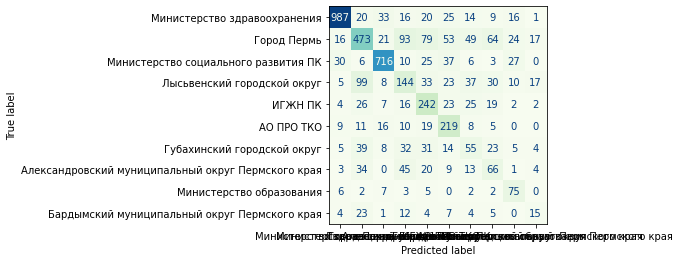

In [127]:
validation('catc', catc, X_valid, y_valid, report=True, importances=False)

## Группа тем

In [45]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(tfidf_embed, 
                                                                train['Группа тем'].tolist(), 
                                                                stratify = train['Группа тем'],
                                                                random_state=45, test_size=0.2)

In [46]:
logit = LogisticRegression(solver = "lbfgs", C=2.0, class_weight="balanced", max_iter=200, multi_class="ovr")
logit.fit(X_train_part, y_train_part)

LogisticRegression(C=2.0, class_weight='balanced', max_iter=200,
                   multi_class='ovr')

In [47]:
# save the model to disk
joblib.dump(logit, 'model/logit_group.sav')
 
# load the model from disk
#logit = joblib.load('model/logit_group.sav')

['model/logit_group.sav']

f1_weight:  0.7794941022432115
Отчет о классификации: 
                                          precision    recall  f1-score   support

                Здравоохранение/Медицина       0.87      0.86      0.87       925
        Социальное обслуживание и защита       0.91      0.88      0.89       906
                                  Дороги       0.73      0.79      0.76       615
                                     ЖКХ       0.84      0.83      0.84       534
                         Благоустройство       0.62      0.61      0.61       495
                        Мусор/Свалки/ТКО       0.78      0.82      0.80       339
                  Общественный транспорт       0.84      0.83      0.83       172
                             Коронавирус       0.66      0.60      0.63       161
                             Образование       0.67      0.71      0.69       139
                            Безопасность       0.69      0.66      0.67        58
                     Связь и телевидение  

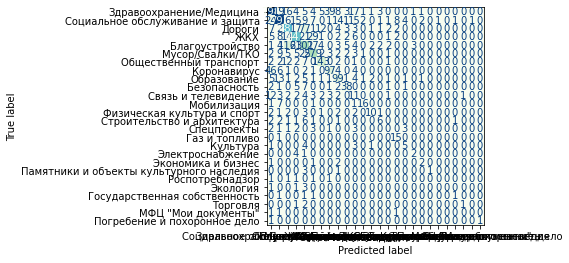

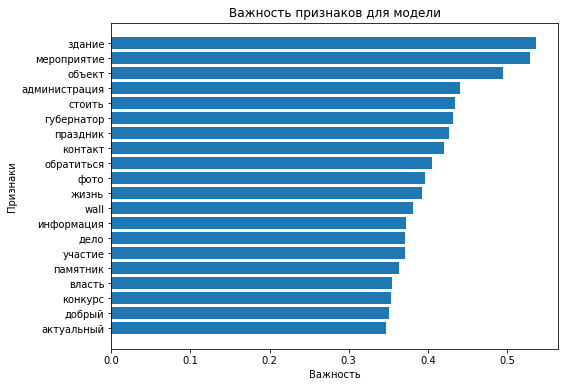

In [48]:
validation('logit', logit, X_valid, y_valid)

### кэтбуст

In [54]:
catc = CatBoostClassifier(loss_function='MultiClass', 
                          eval_metric="TotalF1",  
                          learning_rate=0.2, 
                          max_depth = 6, 
                          n_estimators = 2000, 
                          auto_class_weights='Balanced',
                          #l2_leaf_reg = 1.5,
                          #bagging_temperature=0.1,
                          #colsample_bylevel=0.7,
                          #subsample=0.7,
                          leaf_estimation_iterations=1, random_state=42, task_type='GPU')
catc.fit(X_train_part, y_train_part, eval_set=(X_valid, y_valid), cat_features=None,
         early_stopping_rounds = 100, use_best_model=True, verbose=500)

0:	learn: 0.1363355	test: 0.1142821	best: 0.1142821 (0)	total: 122ms	remaining: 4m 3s
bestTest = 0.5554963224
bestIteration = 295
Shrink model to first 296 iterations.


f1_weight:  0.6626825229900587
Отчет о классификации: 
                                          precision    recall  f1-score   support

                Здравоохранение/Медицина       0.89      0.66      0.76       925
        Социальное обслуживание и защита       0.89      0.63      0.74       906
                                  Дороги       0.75      0.57      0.65       615
                                     ЖКХ       0.82      0.67      0.74       534
                         Благоустройство       0.40      0.52      0.45       495
                        Мусор/Свалки/ТКО       0.79      0.72      0.75       339
                  Общественный транспорт       0.75      0.74      0.75       172
                             Коронавирус       0.54      0.66      0.59       161
                             Образование       0.45      0.71      0.55       139
                            Безопасность       0.47      0.60      0.53        58
                     Связь и телевидение  

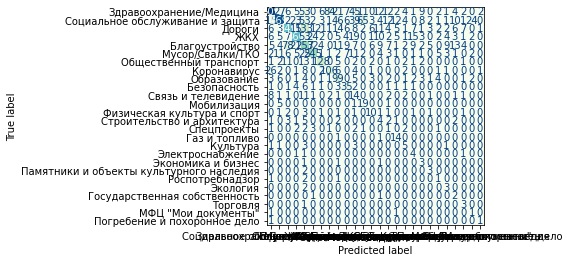

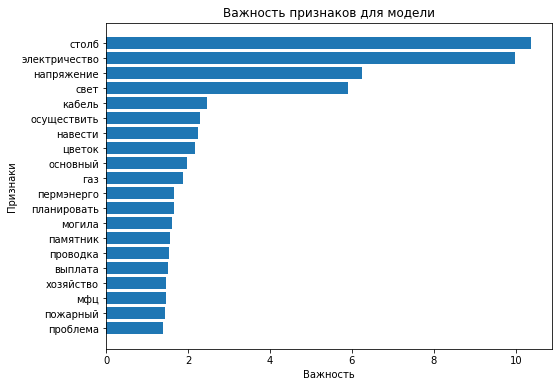

In [55]:
validation('catc', catc, X_valid, y_valid)

In [56]:
#логред с кэтбустом
model_valid_new = postpredict(logit, X_valid, lim=0.1)
print("f1_weight: ", f1_score(y_valid, model_valid_new, average='weighted'))

f1_weight:  0.7794941022432115


In [140]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(embeddings, 
                                                                train['Группа тем'].tolist(), 
                                                                stratify = train['Группа тем'],
                                                                random_state=42, test_size=0.2)

In [141]:
catc = CatBoostClassifier(loss_function='MultiClass', 
                          eval_metric="TotalF1",  
                          learning_rate=0.1, 
                          max_depth = 6, 
                          n_estimators = 8000, 
                          auto_class_weights='Balanced',
                          #l2_leaf_reg = 1.5,
                          #bagging_temperature=0.1,
                          #colsample_bylevel=0.7,
                          #subsample=0.7,
                          leaf_estimation_iterations=1, random_state=42, task_type='GPU')
catc.fit(X_train_part, y_train_part, eval_set=(X_valid, y_valid), cat_features=None,
         early_stopping_rounds = 100, use_best_model=True, verbose=500)

0:	learn: 0.1601647	test: 0.0846621	best: 0.0846621 (0)	total: 52.2ms	remaining: 6m 57s
bestTest = 0.3815433578
bestIteration = 78
Shrink model to first 79 iterations.


f1_weight:  0.6185100738199942
Отчет о классификации: 
                                          precision    recall  f1-score   support

                Здравоохранение/Медицина       0.88      0.68      0.77       925
        Социальное обслуживание и защита       0.87      0.63      0.73       906
                                  Дороги       0.66      0.60      0.63       615
                                     ЖКХ       0.70      0.63      0.66       534
                         Благоустройство       0.49      0.34      0.40       495
                        Мусор/Свалки/ТКО       0.53      0.49      0.51       339
                  Общественный транспорт       0.53      0.78      0.63       171
                             Коронавирус       0.42      0.62      0.50       161
                             Образование       0.42      0.73      0.53       139
                            Безопасность       0.41      0.57      0.48        58
                     Связь и телевидение  

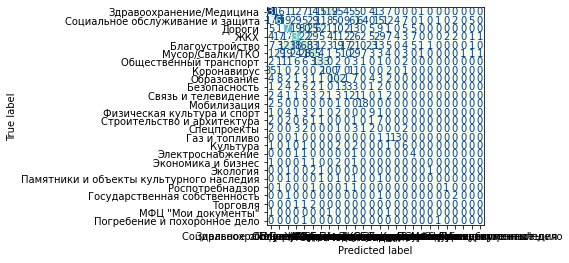

In [142]:
validation('catc', catc, X_valid, y_valid, report=True, importances=False)

### Тема

In [76]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(tfidf_embed, 
                                                                train['Тема'],#.tolist(), 
                                                                stratify = train['Тема'],
                                                                random_state=42, test_size=0.2)

In [77]:
logit = LogisticRegression(solver = "liblinear", C=7.0, class_weight="balanced", max_iter=200)
logit.fit(X_train_part, y_train_part)

LogisticRegression(C=7.0, class_weight='balanced', max_iter=200,
                   solver='liblinear')

In [78]:
# save the model to disk
joblib.dump(logit, 'model/logit_title.sav')
 
# load the model from disk
#logit = joblib.load('model/logit_title.sav')

['model/logit_title.sav']

In [79]:
#validation('logit', logit, X_valid, y_valid)
model_valid = logit.predict(X_valid)
print("f1_weight: ", f1_score(y_valid, model_valid, average='weighted'))

f1_weight:  0.4825882997569517


In [80]:
class_names=pd.Series(y_valid).value_counts().index.tolist()
report = classification_report(y_valid, model_valid, zero_division=0, labels=class_names, output_dict=True, digits=2)
df_rep = pd.DataFrame.from_dict(report).transpose().round(2)
df_rep.head()

,precision,recall,f1-score,support
Дети и многодетные семьи,0.74,0.69,0.71,395.0
Оказание гос. соц. помощи,0.62,0.33,0.43,367.0
★ Нарушение правил очистки дорог от снега и наледи/Обращения о необходимости очистить тротуар от снега и наледи,0.75,0.60,0.67,247.0
Технические проблемы с записью на прием к врачу,0.63,0.43,0.51,187.0
★ Оказание медицинской помощи не в полном объеме/отказ в оказании медицинской помощи,0.48,0.25,0.33,175.0


In [81]:
df_rep[df_rep["f1-score"]<0.1]

,precision,recall,f1-score,support
Освещение неисправно или отсутствует,0.10,0.08,0.09,26.0
Спецпроекты,0.05,0.12,0.08,16.0
Ямы и выбоины на дороге,0.00,0.00,0.00,15.0
★ Отсутствие контейнерной площадки/Проезд к контейнерной площадке,0.08,0.07,0.07,14.0
Содержание гос. образовательных организаций,0.00,0.00,0.00,12.0
"Обустройство асфальтового покрытия парковки, внутридворового проезда, тротуара, пешеходной дорожки, въезда во двор",0.00,0.00,0.00,7.0
Дополнительное образование,0.00,0.00,0.00,5.0
Спортивные мероприятия,0.00,0.00,0.00,5.0
Проблемы в работе горячих линий,0.00,0.00,0.00,5.0
Парки и зоны отдыха,0.00,0.00,0.00,5.0


In [83]:
#temp = pd.DataFrame(data={"Тема": y_valid})
temp=pd.DataFrame(y_valid)
temp["predict"]=model_valid
temp[temp['Тема']!=temp['predict']].sort_values(by=['Тема', 'predict'])

,Тема,predict
1653,Аварийное жилье/переселение,Архитектура города
18627,Аварийное жилье/переселение,Жалобы на управляющие компании
16035,Аварийное жилье/переселение,Освещение неисправно или отсутствует
290,Аварийное жилье/переселение,Плата за ЖКУ и работа ЕИРЦ
10183,Аварийное жилье/переселение,Профильный осмотр
...,...,...
5451,★ Уборка/Вывоз мусора,★ Стихийные свалки в городе/в парках/в лесу
26,★ Уборка/Вывоз мусора,★ Стихийные свалки в городе/в парках/в лесу
11836,★ Уборка/Вывоз мусора,★ Ямы во дворах
14389,★ Ямы во дворах,"Обустройство асфальтового покрытия парковки, в..."


In [84]:
train['Текст инцидента'].loc[3125]

"'Ереванская 35"

## тема кэтбуст

In [85]:
catc = CatBoostClassifier(loss_function='MultiClass', #MultiClassOneVsAll 
                          eval_metric="TotalF1",  
                          learning_rate=0.1, 
                          max_depth = 4, 
                          n_estimators = 5000, 
                          auto_class_weights='Balanced',
                          l2_leaf_reg = 5.5,
                          #bagging_temperature=0.1,
                          #colsample_bylevel=0.7, #CPU
                          #subsample=0.7,
                          leaf_estimation_iterations=1, random_state=42, task_type='GPU')
catc.fit(X_train_part, y_train_part, eval_set=(X_valid, y_valid), #cat_features=None,
         early_stopping_rounds = 100, use_best_model=True, verbose=500)

0:	learn: 0.0161824	test: 0.0171525	best: 0.0171525 (0)	total: 380ms	remaining: 31m 40s
500:	learn: 0.5963343	test: 0.2480861	best: 0.2490943 (457)	total: 2m 57s	remaining: 26m 34s
bestTest = 0.2721266918
bestIteration = 631
Shrink model to first 632 iterations.


In [86]:
#validation('catc', catc, X_valid, y_valid)
model_valid = catc.predict(X_valid)
print("f1_weight: ", f1_score(y_valid, model_valid, average='weighted'))

f1_weight:  0.23567788367939108


In [87]:
class_names=pd.Series(y_valid).value_counts().index.tolist()
report = classification_report(y_valid, model_valid, zero_division=0, labels=class_names, output_dict=True, digits=2)
pd.DataFrame.from_dict(report).transpose().round(2)

,precision,recall,f1-score,support
Дети и многодетные семьи,0.65,0.32,0.43,395.00
Оказание гос. соц. помощи,0.75,0.01,0.02,367.00
★ Нарушение правил очистки дорог от снега и наледи/Обращения о необходимости очистить тротуар от снега и наледи,0.62,0.06,0.11,247.00
Технические проблемы с записью на прием к врачу,0.42,0.07,0.12,187.00
★ Оказание медицинской помощи не в полном объеме/отказ в оказании медицинской помощи,0.50,0.01,0.01,175.00
...,...,...,...,...
Отсутствие аптек,0.00,0.00,0.00,1.00
Общее впечатление,0.00,0.00,0.00,1.00
accuracy,0.23,0.23,0.23,0.23
macro avg,0.23,0.29,0.21,4548.00


In [89]:
#логред с кэтбустом
model_valid_new = postpredict(logit, X_valid, lim=0.1)
print("f1_weight: ", f1_score(y_valid, model_valid_new, average='weighted'))

f1_weight:  0.46793755534214765


In [218]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(embeddings, 
                                                                train['Тема'].tolist(), 
                                                                stratify = train['Тема'],
                                                                random_state=42, test_size=0.2)

In [216]:
catc = CatBoostClassifier(loss_function='MultiClass', 
                          eval_metric="TotalF1",  
                          learning_rate=0.1, 
                          max_depth = 6, 
                          n_estimators = 8000, 
                          auto_class_weights='Balanced',
                          #l2_leaf_reg = 1.5,
                          #bagging_temperature=0.1,
                          #colsample_bylevel=0.7,
                          #subsample=0.7,
                          leaf_estimation_iterations=1, random_state=42, task_type='GPU')
catc.fit(X_train_part, y_train_part, eval_set=(X_valid, y_valid), cat_features=None,
         early_stopping_rounds = 100, use_best_model=True, verbose=500)

0:	learn: 0.0224021	test: 0.0008252	best: 0.0008252 (0)	total: 346ms	remaining: 46m 9s
bestTest = 0.07525748156
bestIteration = 51
Shrink model to first 52 iterations.


In [217]:
validation('catc', catc, X_valid, y_valid, report=False, importances=False)

f1_weight:  0.11093953028468373


In [139]:
class_names=pd.Series(y_valid).value_counts().index.tolist()
report = classification_report(y_valid, model_valid, zero_division=0, labels=class_names, output_dict=True, digits=2)
pd.DataFrame.from_dict(report).transpose().round(2)

,precision,recall,f1-score,support
Дети и многодетные семьи,0.60,0.29,0.39,395.00
Оказание гос. соц. помощи,0.51,0.07,0.12,367.00
★ Нарушение правил очистки дорог от снега и наледи/Обращения о необходимости очистить тротуар от снега и наледи,0.65,0.14,0.23,247.00
Технические проблемы с записью на прием к врачу,0.59,0.23,0.33,187.00
★ Оказание медицинской помощи не в полном объеме/отказ в оказании медицинской помощи,0.30,0.05,0.08,175.00
...,...,...,...,...
Нарушение технологии и (или) сроков производства работ,0.00,0.00,0.00,1.00
Общее впечатление,0.10,1.00,0.18,1.00
accuracy,0.23,0.23,0.23,0.23
macro avg,0.18,0.26,0.18,4547.00


### тема лайтгбм

In [90]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(tfidf_embed, 
                                                                train['Тема'],#.tolist(), 
                                                                stratify = train['Тема'],
                                                                random_state=42, test_size=0.2)

#lgb_train = lightgbm.Dataset(X_train_part, y_train_part, params={'verbose': -1}, free_raw_data=False)
#lgb_eval = lightgbm.Dataset(X_valid, y_valid, params={'verbose': -1},free_raw_data=False)

In [102]:
lgbc = LGBMClassifier(objective = 'multiclass', 
                      metric = 'multi_logloss', #'auc_mu'
                      num_class=len(np.unique(y_train_part)),
                      random_state=42, #device='gpu',
                      class_weight ='balanced', #is_unbalance=True,
                      learning_rate=0.5, #max_depth = 8, 
                      num_leaves = 12,
                      verbose=-1,
                      n_estimators = 2000)

In [103]:
lgbc.fit(X_train_part, y_train_part, # categorical_feature=None, 
         eval_set=[(X_valid, y_valid)],
         eval_metric=['auc_mu'],
         callbacks=[log_evaluation(0), early_stopping(100, verbose=500)],
        )

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc_mu: 0.83773	valid_0's multi_logloss: 17.9211


LGBMClassifier(class_weight='balanced', learning_rate=0.5,
               metric='multi_logloss', n_estimators=2000, num_class=195,
               num_leaves=12, objective='multiclass', random_state=42,
               verbose=-1)

In [101]:
model_valid = lgbc.predict(X_valid)
print("f1_weight: ", f1_score(y_valid, model_valid, average='weighted'))

f1_weight:  0.2530357986658714


In [223]:
class_names=pd.Series(y_valid).value_counts().index.tolist()
report = classification_report(y_valid, model_valid, zero_division=0, labels=class_names, output_dict=True, digits=2)
df_rep = pd.DataFrame.from_dict(report).transpose().round(2)
df_rep.head()

,precision,recall,f1-score,support
Дети и многодетные семьи,0.60,0.29,0.39,395.0
Оказание гос. соц. помощи,0.51,0.07,0.12,367.0
★ Нарушение правил очистки дорог от снега и наледи/Обращения о необходимости очистить тротуар от снега и наледи,0.65,0.14,0.23,247.0
Технические проблемы с записью на прием к врачу,0.59,0.23,0.33,187.0
★ Оказание медицинской помощи не в полном объеме/отказ в оказании медицинской помощи,0.30,0.05,0.08,175.0


In [224]:
df_rep[df_rep["f1-score"]<0.1]

,precision,recall,f1-score,support
★ Оказание медицинской помощи не в полном объеме/отказ в оказании медицинской помощи,0.30,0.05,0.08,175.0
Уборка территорий,0.33,0.05,0.09,82.0
"Благоустройство общественного пространства (парк, сквер, пешеходная зона, бульвар, набережная, центральная улица или площадь)",0.00,0.00,0.00,63.0
★ Информационно-техническая поддержка,0.04,0.26,0.07,46.0
Завышение платы за коммунальные услуги,0.08,0.05,0.06,38.0
...,...,...,...,...
"★ Несанкционированные надписи, рисунки, реклама на фасаде МКД",0.00,0.00,0.00,1.0
Соц.обслуживание прочее,0.00,0.00,0.00,1.0
Культурно-досуговые мероприятия,0.00,0.00,0.00,1.0
"Установка ограждений, препятствующих въезду на тротуар, газон на дворовой территории МКД",0.00,0.00,0.00,1.0


## Тема индекс

In [392]:
#f1_weigh:  0.31963255055694956
X_train_part, X_valid, y_train_part, y_valid = train_test_split(tfidf_embed, 
                                                                train['Тема'].tolist(), 
                                                                stratify = train['Тема'],
                                                                random_state=42, test_size=0.2)

In [396]:
#f1_weigh:  0.32836759506671076 неочищенный f1_weigh:  0.32783186092288114
X_train_part, X_valid, y_train_part, y_valid = train_test_split(embeddings, 
                                                                train['Тема'].tolist(), 
                                                                stratify = train['Тема'],
                                                                random_state=42, test_size=0.2)

In [202]:
#f1_weigh:  0.1286313765527402
X_train_part, X_valid, y_train_part, y_valid = train_test_split(doc2vec_embed, 
                                                                train['Тема'].tolist(), 
                                                                stratify = train['Тема'],
                                                                random_state=42, test_size=0.2)

In [397]:
t = index_annoy(X_train_part)

In [398]:
y_predict=predict_nns(t, X_valid)

  0%|          | 0/4546 [00:00<?, ?it/s]

In [205]:
print("f1_weigh: ", f1_score(y_valid, y_predict, average='weighted'))

f1_weigh:  0.1286313765527402


In [106]:
train["Тема"].value_counts(dropna=False)[170:]

Тема
Строительство объектов по обращению с отходами                                              11
★ Нарушение правил уборки от снега и наледи детской игровой и спортивной площадки           11
Восстановление газоснабжения                                                                11
Лифт неисправен или отключен                                                                10
Строительство социальных объектов                                                           10
Подключение к водоснабжению                                                                 10
Волонтерство                                                                                10
Нехватка мест в школах                                                                      10
Государственные услуги                                                                      10
Предложение дороги в план ремонта                                                           10
Выплаты стипендий                            